In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Install required packages**:

In [ ]:
!pip install matplotlib muon numpy pandas scanpy seaborn pysam anndata2ri rpy2 igraph leidenalg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.7/293.7 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 97.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 115.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 79.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.9/169.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.4/255.4 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 3.8 MB/s eta 0:00:00


# **Feature Selection**:

We now have a normalized data representation that still preserves biological heterogeneity but with reduced technical sampling effects in gene expression. Single-cell RNA-seq datasets usually contain up to 30,000 genes and so far we only removed genes that are not detected in at least 20 cells. However, many of the remaining genes are not informative and contain mostly zero counts. Therefore, a standard preprocessing pipeline involves the step of feature selection which aims to exclude uninformative genes which might not represent meaningful biological variation across samples.

In [ ]:
import logging

import anndata2ri
import matplotlib.pyplot as plt
import numpy as np
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
import scanpy as sc
import seaborn as sns

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()

%load_ext rpy2.ipython

In [ ]:
%%R
install.packages("BiocManager")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'https://cran.rstudio.com/src/contrib/BiocManager_1.30.26.tar.gz'
Content type 'application/x-gzip' length 594489 bytes (580 KB)
downloaded 580 KB


The downloaded source packages are in
	‘/tmp/Rtmpf223IG/downloaded_packages’


In [ ]:
%%R
BiocManager::install("scry")

Update all/some/none? [a/s/n]: a


'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com
Bioconductor version 3.21 (BiocManager 1.30.26), R 4.5.1 (2025-06-13)
Installing package(s) 'BiocVersion', 'scry'
also installing the dependencies ‘formatR’, ‘lambda.r’, ‘futile.options’, ‘matrixStats’, ‘abind’, ‘XVector’, ‘UCSC.utils’, ‘GenomeInfoDbData’, ‘futile.logger’, ‘snow’, ‘BH’, ‘BiocGenerics’, ‘MatrixGenerics’, ‘S4Vectors’, ‘IRanges’, ‘S4Arrays’, ‘SparseArray’, ‘GenomicRanges’, ‘Biobase’, ‘GenomeInfoDb’, ‘BiocParallel’, ‘ScaledMatrix’, ‘irlba’, ‘rsvd’, ‘beachmat’, ‘assorthead’, ‘DelayedArray’, ‘glmpca’, ‘SingleCellExperiment’, ‘SummarizedExperiment’, ‘BiocSingular’

trying URL 'https://cran.rstudio.com/src/contrib/formatR_1.14.tar.gz'
trying URL 'https://cran.rstudio.com/src/contrib/lambda.r_1.2.4.tar.gz'
trying URL 'https://cran.rstudio.com/src/contrib/futile.options_1.0.1.tar.gz'
trying

In [ ]:
%%R
library(scry)

Next, we load the already normalized dataset. Deviance works on raw counts so there is no need to replace adata.X with one of the normalized layers, but we can directly use the object as it was stored in the normalization notebook.

In [ ]:
adata = sc.read(
    filename="/content/drive/MyDrive/MultiOmicsProj/new_data/normalization_processed_rnaseq_data.h5ad",

)

Similar to before, we save the AnnData object in our R environment.

In [ ]:
import rpy2.robjects as ro
from scipy.sparse import issparse

# Extract the raw count matrix from adata.X
count_matrix = adata.X

# Transpose for R's 'genes x cells' format
count_matrix_r = count_matrix.T

# Convert to a dense NumPy array to ensure the transfer works
if issparse(count_matrix_r):
    data_for_r = count_matrix_r.toarray()
else:
    data_for_r = count_matrix_r

# Transfer the dense matrix to R's global environment
ro.globalenv['adata'] = data_for_r

We can now directly call feature selection with deviance on the non-normalized counts matrix and export the binomial deviance values as a vector.

In [ ]:
# Run the necessary R commands as a string
ro.r('''
    library(scry)
    library(SingleCellExperiment)
    # Create the SCE object from the matrix we just transferred
    sce <- SingleCellExperiment(list(counts=count_matrix_for_r))
    # Run the feature selection
    sce <- devianceFeatureSelection(sce)
''')

# pull the results from the 'sce' object that exists in R

binomial_deviance = ro.r('rowData(sce)$binomial_deviance')

In [ ]:
# Convert the result from R into a NumPy array for sorting
binomial_deviance = np.array(binomial_deviance)

# Get the indices of the 4000 genes with the highest deviance scores
idx = binomial_deviance.argsort()[-4000:]

# Create a boolean mask to mark these genes as 'True'
mask = np.zeros(adata.var_names.shape, dtype=bool)
mask[idx] = True

# Store the boolean mask and the deviance scores in adata.var
adata.var["highly_deviant"] = mask
adata.var["binomial_deviance"] = binomial_deviance


#Verify the result
print(f"Number of highly deviant genes selected: {adata.var.highly_deviant.sum()}")
print("\nTop 5 highly deviant genes:")
print(adata.var.sort_values('binomial_deviance', ascending=False).head())

Number of highly deviant genes selected: 4000

Top 5 highly deviant genes:
                gene_ids    feature_types  genome                  interval  \
MALAT1   ENSG00000251562  Gene Expression  GRCh38   chr11:65497687-65505207   
SLC13A1  ENSG00000081800  Gene Expression  GRCh38  chr7:123181145-123199969   
ITGB8    ENSG00000105855  Gene Expression  GRCh38    chr7:20330701-20330900   
PTH2R    ENSG00000144407  Gene Expression  GRCh38  chr2:208359713-208406831   
OXR1     ENSG00000164830  Gene Expression  GRCh38  chr8:106359475-106726185   

            mt   ribo     hb  n_cells_by_counts  mean_counts  \
MALAT1   False  False  False              22755   262.624846   
SLC13A1  False  False  False              16676     7.564421   
ITGB8    False  False  False              20513    14.469524   
PTH2R    False  False  False              22030    33.109081   
OXR1     False  False  False              21614    20.603856   

         log1p_mean_counts  pct_dropout_by_counts  total_counts  

Last, we visualise the feature selection results. We use a scanpy function to compute the mean and dispersion for each gene across all cells.

In [ ]:
sc.pp.highly_variable_genes(adata, layer="scran_normalization")

In [ ]:
adata.var

,gene_ids,feature_types,genome,interval,mt,ribo,hb,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,highly_deviant,binomial_deviance,highly_variable,means,dispersions,dispersions_norm
AL627309.1,ENSG00000238009,Gene Expression,GRCh38,chr1:120931-133723,False,False,False,65,0.002854,0.002850,99.714562,65.0,4.189655,47,False,514.028573,False,0.002436,-0.087934,-1.051347
AL627309.5,ENSG00000241860,Gene Expression,GRCh38,chr1:149706-173862,False,False,False,334,0.015062,0.014950,98.533286,343.0,5.840641,248,False,2034.048532,False,0.013383,-0.025641,-0.738284
LINC01409,ENSG00000237491,Gene Expression,GRCh38,chr1:778757-803934,False,False,False,1803,0.091823,0.087849,92.082382,2091.0,7.645876,1295,False,6945.537218,False,0.074729,0.082604,-0.194281
FAM87B,ENSG00000177757,Gene Expression,GRCh38,chr1:817370-817371,False,False,False,30,0.001361,0.001360,99.868259,31.0,3.465736,20,False,277.482431,False,0.001157,0.052814,-0.343998
LINC01128,ENSG00000228794,Gene Expression,GRCh38,chr1:827597-860227,False,False,False,1250,0.061391,0.059580,94.510803,1398.0,7.243513,869,False,5328.208859,False,0.049744,0.058335,-0.316250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AL354822.1,ENSG00000278384,Gene Expression,GRCh38,GL000218.1:54892-54893,False,False,False,2089,0.105612,0.100399,90.826454,2405.0,7.785721,1568,False,7455.807670,False,0.088117,0.027579,-0.470820
AL592183.1,ENSG00000273748,Gene Expression,GRCh38,GL000219.1:83310-83311,False,False,False,2179,0.114439,0.108351,90.431231,2606.0,7.865955,1678,False,7998.131996,False,0.096512,0.082346,-0.195578
AC240274.1,ENSG00000271254,Gene Expression,GRCh38,KI270711.1:24649-29626,False,False,False,731,0.033770,0.033212,96.789917,769.0,6.646390,528,False,3571.266105,False,0.028573,-0.024810,-0.734110
AC007325.4,ENSG00000278817,Gene Expression,GRCh38,KI270734.1:131493-131494,False,False,False,189,0.008475,0.008440,99.170033,193.0,5.267858,111,False,1106.314154,False,0.006131,-0.011136,-0.665388


We inspect our results by plotting dispersion versus mean for the genes and color by ‘highly_deviant’.

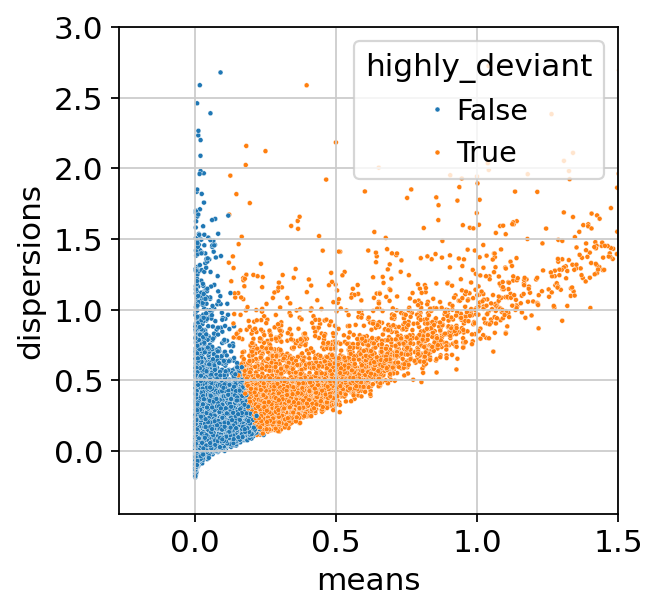

In [ ]:
ax = sns.scatterplot(
    data=adata.var, x="means", y="dispersions", hue="highly_deviant", s=5
)
ax.set_xlim(None, 1.5)
ax.set_ylim(None, 3)
plt.show()

This scatter plot distinguishes biologically informative genes from technical noise. The x-axis represents the mean expression of each gene, while the y-axis shows its dispersion (variance relative to the mean). The genes colored in orange (True) are identified as "highly deviant" or highly variable genes (HVGs); these genes exhibit higher-than-expected variance and are selected for downstream analysis (such as PCA and clustering) because they likely drive biological heterogeneity. The blue points (False) represent genes with stable or low variance, which are excluded from the primary analysis to reduce dimensionality and noise.

In [ ]:

adata.write("/content/drive/MyDrive/MultiOmicsProj/new_data/RNAseq_processed_feature_selection.h5ad")